# **Drug Similarity**
Prince Ofuoku 25/03/2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Introduction**
In this notebook, I'll collect a list of drugs, their target(gene), chemical structures from the Therapeutic Target Database (TTD) (https://db.idrblab.net/ttd/full-data-download). <br>

Following that, chemical strutures will be represented as molecular fingerprints, which allow us to compute the structural similarities between drug pairs. 

This analysis provides valuable insights into the relationships between drugs, their potential biological activities, and possible shared targets, thereby aiding in various aspects of drug discovery and development.

In [ ]:
import pandas as pd
import numpy as np
import re

fp = "/content/drive/MyDrive/Project/data/"

### Drugs data
The code below extracts drugs id, chemical structure, drug type, and highest clincal status from the text file. The contents of the file are structured in blocks and seperated by tabs. I opened the file in a text editor before coming up with the code to extract the relevant data.

In [ ]:
with open(fp + "P1-02-TTD_drug_download.txt") as f:
  ids = []
  id2smiles = {}
  id2type = {}
  id2status = {}

  for line in f:
    line = [item.strip() for item in line.split("\t")]
    if len(line) == 3:
      id, key, value = line
      if key == 'DRUG__ID':
        ids.append(id)
      elif key == 'DRUGSMIL':
        id2smiles[id] = value
      elif key == 'DRUGTYPE':
        id2type[id] = value
      elif key == 'HIGHSTAT':
        id2status[id] = value


drugs = pd.DataFrame({"drug_id":ids})
drugs["status"] = drugs["drug_id"].map(id2status)
drugs["type"] = drugs["drug_id"].map(id2type)
drugs["smiles"] = drugs["drug_id"].map(id2smiles)
drugs.head()

,drug_id,status,type,smiles
0,D00AAN,Investigative,Small molecular drug,C1CCN2CCC3C(=CC(CCC=CC1)(C4C3(C2)CC5N4CCCC(=O)...
1,D00AAU,Investigative,Small molecular drug,CCC(C1=CC(=CC=C1)O)C(CC)C2=CC(=CC=C2)O
2,D00ABE,Phase 2,NaN,NaN
3,D00ABO,Phase 1,Small molecular drug,C1CN(CCN1)C(=O)C2=CC=C(C=C2)C=CC3=NNC4=CC=CC=C43
4,D00ABW,Discontinued in Phase 1,NaN,NaN


**SMILES** (Simplified Molecular Input Line Entry System) is a widely used chemical notation system that represents chemical structures using ASCII strings. The SMILES notation provides a simple and human-readable way to describe the structure of a chemical compound, including atoms, bonds, and stereochemistry.<br>

For example, the SMILES notation for ethanol is CCO, where the two carbon atoms (C) are connected by a single bond (implicitly represented), and the second carbon atom is connected to an oxygen atom (O) by a single bond.<br>


In [ ]:
drugs.type.value_counts()

**A small molecular drug** is characterized by its relatively low molecular weight, typically under 900 daltons. These drugs are usually composed of organic compounds with a well-defined chemical structure. Due to their small size, they can easily penetrate cell membranes, which allows them to interact with a variety of intracellular and extracellular targets, such as enzymes, receptors, or signaling pathways.
<br><br>
For the drug repurposing tasks, I'll choose only the small molecular drugs.

In [ ]:
drugs = drugs[drugs.type == "Small molecular drug"]

In [ ]:
drugs.status.value_counts()

### Clinical Status
- Investigative: This category represents drugs that are still under investigation and have not yet advanced to the clinical trial stage. These drugs may still be in preclinical development or early research stages.
- Phase 1: Tests the safety of the drug in a small group of people (usually healthy volunteers) to determine safe dosage ranges and identify potential side effects.
- Phase 2: Evaluates the drug's effectiveness and further assesses its safety in a larger group of patients with the targeted condition.
- Phase 3: Confirms the drug's effectiveness, monitors side effects, and compares it to commonly used treatments in an even larger group of patients.
- Phase 4: Occurs after the drug has been approved, focusing on post-marketing surveillance to gather more information about the drug's long-term safety, effectiveness, and optimal use.
- Approved: Drugs in this category have successfully completed the clinical trial process and have been granted regulatory approval for marketing and use by the general public.
- Patented: This category refers to drugs that have been granted patent protection. These drugs may be at any stage of development, from preclinical research to approved drugs.

In [ ]:
selected_status = ["Approved","Phase 3","Phase 4"]

drugs = drugs[drugs.status.isin(selected_status)]
drugs.reset_index(drop=True, inplace=True)

### Drug names and IDs for crossreferencing
A **CAS RN** (Chemical Abstracts Service registry number) is a unique identifier assigned to a specific chemical substance by the Chemical Abstracts Service, a division of the American Chemical Society. CAS numbers are used to provide a standardized and internationally recognized system for identifying and referring to chemical substances in scientific literature, databases, and regulatory documents.


"P1-03-TTD_crossmatching.txt" was downloaded from TTD 

I create utility dictionaries to mapped TTD drugs IDs to generic name, cas ids and pubchem ids for easy crossref with other databases

In [ ]:
with open(fp + "P1-03-TTD_crossmatching.txt") as f:
  id2drug = {}
  id2cas = {}
  id2pubchem = {}

  for line in f:
    line = [item.strip() for item in line.split("\t")]
    if len(line) == 3:
      id, key, value = line
      if key == 'DRUGNAME':
          id2drug[id] = value
      elif key == 'CASNUMBE':
          id2cas[id] = value
      elif key == 'PUBCHCID':
          id2pubchem[id] = value

In [ ]:
drugs["drug_name"] = drugs["drug_id"].map(id2drug)
drugs["cas_rn"] = drugs["drug_id"].map(id2cas)
drugs["pubchem"] = drugs["drug_id"].map(id2pubchem)

Arrange columns

In [ ]:
drugs = drugs[["drug_id","drug_name","status","cas_rn","pubchem","smiles"]]

In [ ]:
drugs.isna().sum()

drug_id        0
drug_name     60
status         0
cas_rn       273
pubchem       62
smiles        62
dtype: int64

Drop missing values, duplicates. No point keeping drugs without the three key infos needed for downstream tasks.

In [ ]:
drugs = drugs.dropna(subset=["smiles","cas_rn","pubchem"]).drop_duplicates().reset_index(drop=True)

In [ ]:
drugs.isna().sum()

drug_id      0
drug_name    0
status       0
cas_rn       0
pubchem      0
smiles       0
dtype: int64

In [ ]:
drugs.head()

,drug_id,drug_name,status,cas_rn,pubchem,smiles
0,D00AEQ,Hydroxyprogesterone,Approved,CAS 68-96-2,6238,CC(=O)C1(CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C)O
1,D00AMQ,Ethanol,Approved,CAS 64-17-5,702,CCO
2,D00AOJ,Docosanol,Approved,CAS 661-19-8,12620,CCCCCCCCCCCCCCCCCCCCCCO
3,D00AWT,Propericiazine,Approved,CAS 2622-26-6,4747,C1CN(CCC1O)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C#N
4,D00AXJ,Miconazole,Approved,CAS 22916-47-8,4189,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...


Clean cas_rn
- I inspected the cas_rn column and the namings are not consistent.
- The lambda function below strips away the "CAS" if present

In [ ]:
clean_cas = lambda x: x.split()[1] if x.startswith("CAS") else x

drugs["cas_rn"] = drugs["cas_rn"].apply(clean_cas)
drugs.head()

,drug_id,drug_name,status,cas_rn,pubchem,smiles
0,D00AEQ,Hydroxyprogesterone,Approved,68-96-2,6238,CC(=O)C1(CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C)O
1,D00AMQ,Ethanol,Approved,64-17-5,702,CCO
2,D00AOJ,Docosanol,Approved,661-19-8,12620,CCCCCCCCCCCCCCCCCCCCCCO
3,D00AWT,Propericiazine,Approved,2622-26-6,4747,C1CN(CCC1O)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C#N
4,D00AXJ,Miconazole,Approved,22916-47-8,4189,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...


In [ ]:
drugs.status.value_counts()

Approved    2337
Phase 3      425
Phase 4       38
Name: status, dtype: int64

In [ ]:
drugs.shape

(2800, 6)

Write df to a file

In [ ]:
drugs.to_csv(fp+"drugs_TTD.csv", index=False)

### Drugs and their targets (gene/protein)
The file below contain all drugs with a protein target available in TTD

In [ ]:
drug_target = pd.read_excel(fp+"P1-07-Drug-TargetMapping.xlsx")
drug_target.head()

,TargetID,DrugID,Highest_status,MOA
0,T71390,D07OAC,Investigative,Inhibitor
1,T70309,D07OAC,Investigative,Inhibitor
2,T97071,D0Y6UB,Investigative,Inhibitor
3,T86679,D0J2UW,Investigative,Agonist
4,T19229,D0UZ9U,Investigative,Modulator


It contains drugs in various categories but I'll keep only drug ids selected from above filters (from `drugs`).

In [ ]:
drug_target = drug_target[drug_target.DrugID.isin(drugs.drug_id.values)]

In [ ]:
drug_target.MOA.value_counts()

In [ ]:
drug_target.DrugID.nunique()

### Target names and Uniprot IDs
- targets were given as TTD IDs. So I created a dict for mapping ids to thier standard names and uniprot ids
- Again, the codes below was tailored to the structure of the file, which I opened in an editor beforehand.

In [ ]:
with open(fp + "P2-01-TTD_uniprot_all.txt") as f:
  ids, uniprots, names = [],[],[]

  for line in f:
    line = [i.strip() for i in line.split("\t")]
    if len(line) == 3 and line[1] == "UNIPROID":
      ids.append(line[0])
      uniprots.append(line[2])
    elif len(line) == 3 and line[1] == "TARGNAME":
      names.append(line[2]) 

targets = pd.DataFrame({"target_id" : ids,
                        "uniprot_id" : uniprots,
                        "target_names" : names})
targets.head()

- map ids to target names

In [ ]:
id2uniprot = {row[0]:row[1] for _,row in targets.iterrows()}
id2targetname = {row[0]:row[2] for _,row in targets.iterrows()}

drug_target["uniprot_id"] = drug_target.TargetID.map(id2uniprot)
drug_target["target_names"] = drug_target.TargetID.map(id2targetname)
drug_target.head()

In [ ]:
drug_target.isna().sum()

In [ ]:
drug_target = drug_target.dropna().drop_duplicates().reset_index(drop=True)

- Similar mappings for drug ids

In [ ]:
drug_target["cas_rn"] = drug_target.DrugID.map(id2cas)
drug_target["cas_rn"] = drug_target["cas_rn"].apply(clean_cas)

In [ ]:
drug_target.isna().sum()

TargetID          0
DrugID            0
Highest_status    0
MOA               0
uniprot_id        0
target_names      0
cas_rn            0
dtype: int64

In [ ]:
drug_target.to_csv(fp+"drug_target.csv", index=False)

### Drugs and their clinical Indications
The code below extracts drug id, drug name and their disease indications (ie the disease they have been approved to treat) from the file "P1-05-Drug_disease.txt"; which was downloaded from TTD

In [ ]:
with open(fp + "P1-05-Drug_disease.txt") as f:
  drug_ids = []
  indications = []
  drug = None
  for line in f:
      if not line:
          continue

      line = line.strip().split("\t")

      if line[0] == "TTDDRUID":
          drug = line[1]
      elif line[0] == "INDICATI" and drug:
          indication = line[1]
          if indication.endswith("Approved"):
            drug_ids.append(drug)
            indications.append(indication)

drug_indication = pd.DataFrame({"Drug_ID": drug_ids, "Indication": indications})
drug_indication.head()

,Drug_ID,Indication
0,D00AEQ,Solid tumour/cancer [ICD-11: 2A00-2F9Z] Approved
1,D00AEV,Human immunodeficiency virus infection [ICD-11...
2,D00ALE,Influenza virus infection [ICD-11: 1E30-1E32] ...
3,D00AMQ,Cystitis [ICD-11: GC00] Approved
4,D00AMQ,Chronic pain [ICD-11: MG30] Approved


**ICD** (International Classification of Diseases) codes are a standardized system for classifying diseases, maintained by the World Health Organization (WHO). ICD-11 is the 11th revision of the classification system.


The next code chunck splits the indication column into disease name and ICD code

In [ ]:
def fx(indication):
    name, icd = re.match(r"^(.+)\s\[(.+)\]\sApproved$", indication).groups()
    return name.strip(), icd.strip()

drug_indication['Disease'], drug_indication['ICD_code'] = zip(*drug_indication['Indication'].apply(fx))

drug_indication = drug_indication.drop(columns=['Indication'])
drug_indication

In [ ]:
drug_indication = drug_indication[drug_indication.Drug_ID.isin(drugs.drug_id)].reset_index(drop=True)

- Map ids to cas_rn as before

In [ ]:
drug_indication["cas_rn"] = drug_indication.Drug_ID.map(id2cas)
drug_indication.dropna(inplace=True)
drug_indication["cas_rn"] = drug_indication["cas_rn"].apply(clean_cas)
drug_indication

In [ ]:
grouped_data = drug_indication.groupby('ICD_code')['Disease'].unique()

# Display the ICD codes with more than one associated disease name
for icd_code, disease_names in grouped_data.items():
    if len(disease_names) > 1:
        print(f"{icd_code}: {disease_names}")


In [ ]:
drug_indication.to_csv(fp+"drug_indication.csv", index=False)

## **Chemoinformatics**
### drug-drug similarity
In this section, I'll use the `RDKit` package for computational chemistry. Specifically, I'll compute the molecular fingerprints for each compound and compute a similarity score for each pair of compound.<br>
**Morgan fingerprints** capture the topological and connectivity information of a molecule, including atom types, bond types, and the arrangement of atoms in the molecular structure. By encoding the presence or absence of specific substructures within the molecule, these fingerprints allow for a compact and efficient representation of the compound's structural features.<br>
**Molecular similarity**: Comparing the Morgan fingerprints of two compounds can help determine their structural similarity, which is often correlated with similar biological activities or physicochemical properties.

In [ ]:
!pip install rdkit

In [ ]:
import rdkit

rdkit.__version__

'2022.09.5'

The code below generates the Morgan Fingerprint for each molecule
- `radius` determines the size of the local environment around each atom that is considered when generating the fingerprint. A radius of 2 means that the fingerprint will take into account not only the immediate neighbors of an atom but also the neighbors of those neighbors. This allows the fingerprint to capture more information about the local structure around each atom in the molecule.

- `nBits` defines the length of the fingerprint vector. In this case, it will be a fixed-length binary representation of 1024 bits. The larger the nBits, the more information the fingerprint can capture and the more unique the fingerprint will be, potentially reducing the risk of collisions (i.e., different molecules having identical fingerprints). However, larger fingerprints also require more memory and computational resources to process.

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# Convert SMILES to RDKit Mol objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in drugs.smiles]

radius = 2
nBits = 1024
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits) for mol in molecules]


The **Tanimoto similarity**, also known as the **Jaccard similarity**, is a metric used to measure the similarity between two sets, typically binary sets, such as molecular fingerprints. In the context of molecular fingerprints, the Tanimoto similarity is used to quantify the similarity between the chemical structures of two molecules.

The Tanimoto similarity is calculated as the ratio of the intersection (the number of common bits set to 1) to the union (the total number of bits set to 1) of the two sets or fingerprints:

Tanimoto similarity = (A ∩ B) / (A ∪ B)

where A and B are the two fingerprints being compared. The Tanimoto similarity value ranges from 0 to 1, where 0 indicates no similarity and 1 indicates a perfect match.

In [ ]:
# Initialize lists to store query, target, and similarity data
query_drug, target_drug, similarities = [], [], []

# Compute pairwise Tanimoto similarities without duplicates
for i, query_fp in enumerate(fingerprints[:-1]):
    target_fps = fingerprints[i+1:]
    scores = DataStructs.BulkTanimotoSimilarity(query_fp, target_fps)

    # Append SMILES strings and similarity values to the respective lists
    query_drug.extend([drugs.drug_name[i]] * len(scores))
    target_drug.extend(drugs.drug_name[i+1:])
    similarities.extend(scores)


drug_similarity = pd.DataFrame({'query': query_drug, 'target': target_drug, 'similarity': similarities})

In [ ]:
drug_similarity

#### Visualize distribution of similarity scores

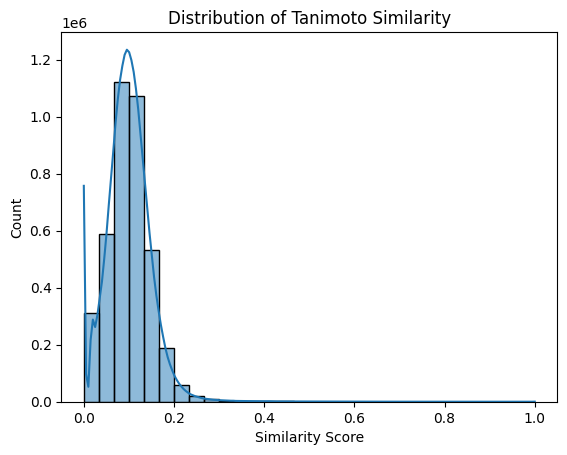

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=drug_similarity, x='similarity', bins=30, kde=True)
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.title('Distribution of Tanimoto Similarity')
plt.show()


#### **Choosing a threshold score for similarity**
The histogram above shows that most of the drug pairs have a score between 0.0 and 0.2.<br>

In their study, Baldi et al. found the mean score to be 0.17, and majority of their scores were less than 0.4. In addition, the authors suggested a cutoff of 0.4 might be a good one (Baldi et al., 2008)<br>

It has long been claimed that a score of 0.85 reflects a high probability that two molecules shares similar activity. However, "the 0.85 Myth" was debunked in a recent study. It was established that thresholds are subjective and there is no standard threshold (Maggiora et al, 2014)

Here, I pick a threshold of 0.75 (chosen arbitrarily)


In [ ]:
threshold = 0.75
drug_similarity = drug_similarity[(drug_similarity["similarity"]>threshold)]

In [ ]:
drug_similarity.shape

(435, 3)

In [ ]:
drug_similarity.to_csv(fp + "drug_similarity.csv", index=False)

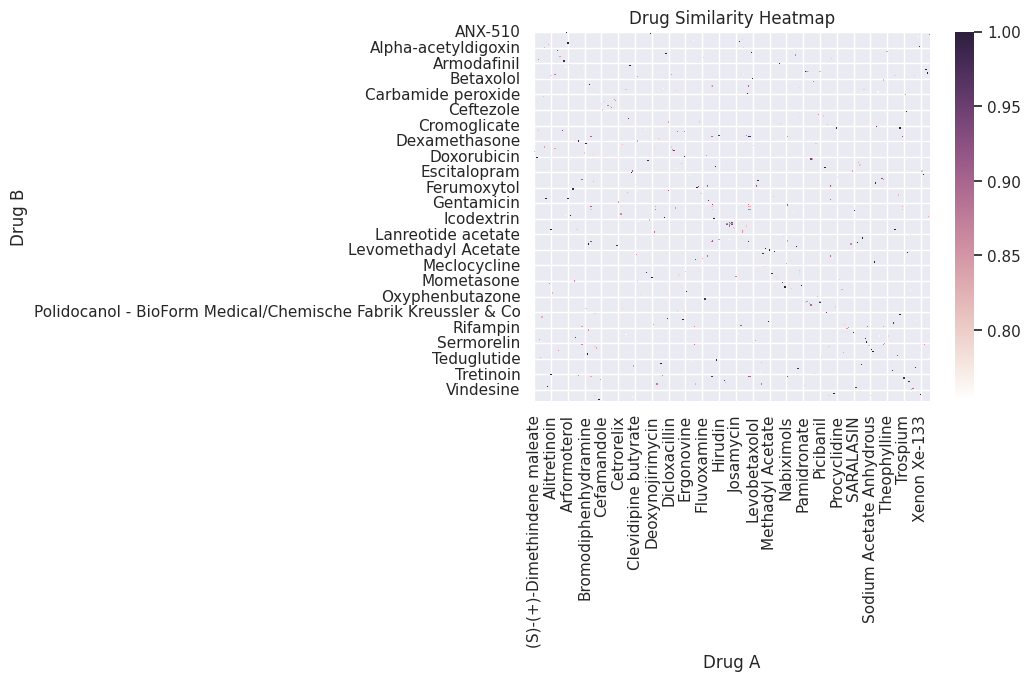

In [ ]:
drug_similarity_matrix = drug_similarity.pivot(index='query', columns='target', values='similarity')

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.set(style="darkgrid")

# Create heatmap
sns.heatmap(drug_similarity_matrix, cmap=cmap)

plt.title('Drug Similarity Heatmap')
plt.xlabel('Drug A')
plt.ylabel('Drug B')
plt.show()


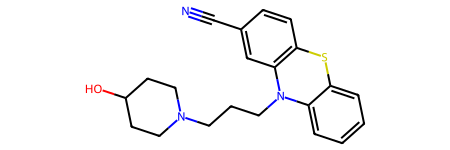

In [ ]:
Chem.MolFromSmiles(drugs.SMILES[3])

## Refrences

Maggiora G, Vogt M, Stumpfe D, Bajorath J. Molecular similarity in medicinal chemistry. J Med Chem. 2014;57(8):3186-3204. doi:10.1021/jm401411z

Pierre Baldi, Ryan W. Benz, BLASTing small molecules—statistics and extreme statistics of chemical similarity scores, Bioinformatics, Volume 24, Issue 13, July 2008, Pages i357–i365, https://doi.org/10.1093/bioinformatics/btn187
